In [1]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scripts.SentimentThematicAnalysis.analyze_sentiment import sentiment
from scripts.SentimentThematicAnalysis.keyword_extraction import thematic

/home/abel/Desktop/Projects/fintech-review-analytics/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sentiment()
thematic()

Device set to use cpu


#  EDA Visualizations for Sentiment & Thematic Analysis

In [22]:
# 📦 Load sentiment data
cbe_sentiment_df = pd.read_csv(
    './../data/analyzed/sentiment_commercial_bank_of_ethiopia_reviews.csv')
abyssinia_sentiment_df = pd.read_csv(
    './../data/analyzed/sentiment_bank_of_abyssinia_reviews.csv')
dashen_sentiment_df = pd.read_csv(
    './../data/analyzed/sentiment_dashen_bank_reviews.csv')

# 📦 Load thematic data
cbe_thematic_df = pd.read_csv(
    './../data/thematically_analyzed/commercial_bank_of_ethiopia_reviews_thematic_analysis.csv')
abyssinia_thematic_df = pd.read_csv(
    './../data/thematically_analyzed/bank_of_abyssinia_reviews_thematic_analysis.csv')
dashen_thematic_df = pd.read_csv(
    './../data/thematically_analyzed/dashen_bank_reviews_thematic_analysis.csv')

# 🧬 Add bank name if missing
cbe_sentiment_df['bank'] = 'CBE'
abyssinia_sentiment_df['bank'] = 'BOA'
dashen_sentiment_df['bank'] = 'Dashen'

cbe_thematic_df['bank'] = 'CBE'
abyssinia_thematic_df['bank'] = 'BOA'
dashen_thematic_df['bank'] = 'Dashen'

# 🔗 Merge all
sentiment_df = pd.concat(
    [cbe_sentiment_df, abyssinia_sentiment_df, dashen_sentiment_df], ignore_index=True)
thematic_df = pd.concat(
    [cbe_thematic_df, abyssinia_thematic_df, dashen_thematic_df], ignore_index=True)

# 💡 Optional: Merge thematic and sentiment on 'review_text'
merged_df = pd.merge(thematic_df, sentiment_df[['review_text', 'sentiment_score', 'sentiment_label', 'bank']],
                     on=['review_text', 'bank'], how='left')

print(
    f"✅ Combined {len(sentiment_df)} sentiment reviews and {len(thematic_df)} thematic reviews.")
merged_df[['review_text', 'identified_theme', 'sentiment_label', 'bank']].head()

output_dir = './../docs/'

✅ Combined 1200 sentiment reviews and 1200 thematic reviews.


## 1. Sentiment Score by Rating per Bank
### Retaining Users, Proportion of positive, negative, neutral reviews for each bank.

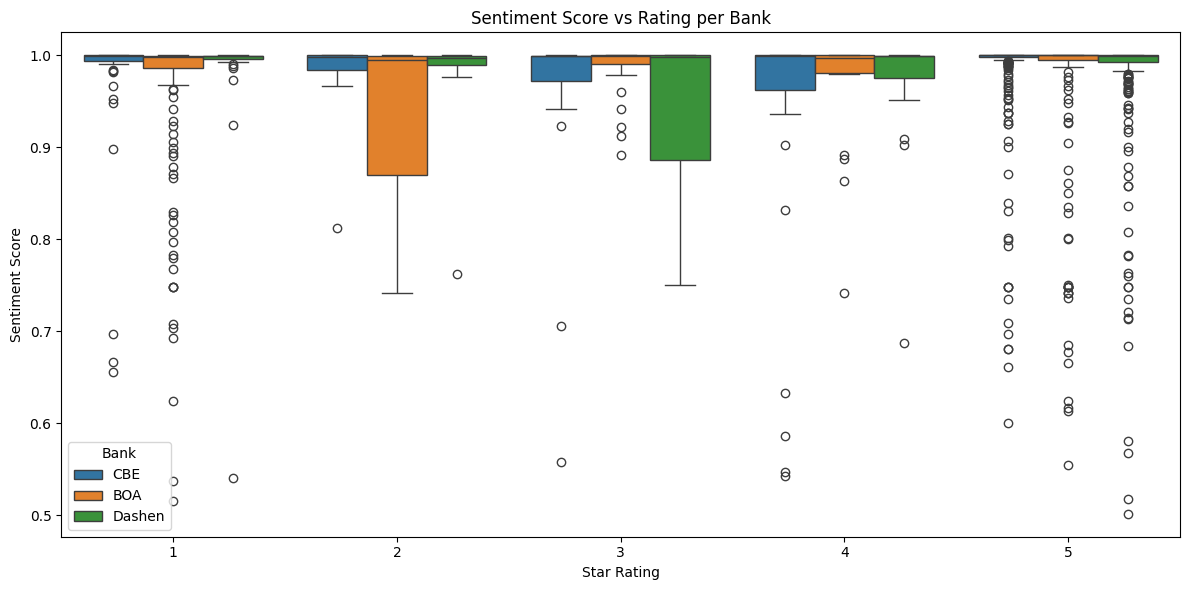

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=sentiment_df, x='rating', y='sentiment_score', hue='bank')
plt.title('Sentiment Score vs Rating per Bank')
plt.xlabel('Star Rating')
plt.ylabel('Sentiment Score')
plt.legend(title='Bank')
plt.tight_layout()
plt.savefig(os.path.join(
    output_dir, 'rating_sentiment_score.png'))
plt.show()

# Average Sentiment Score by Bank

/tmp/ipykernel_200484/3937848872.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_sentiment.values, y=avg_sentiment.index, palette='coolwarm')


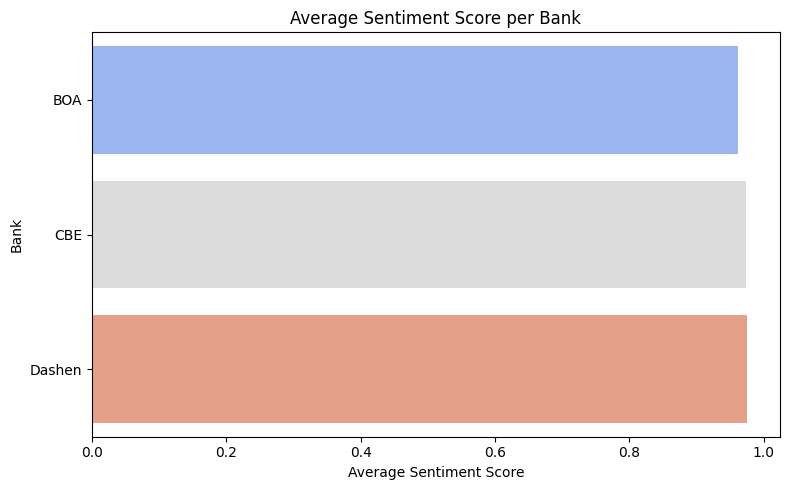

In [24]:
avg_sentiment = sentiment_df.groupby(
    'bank')['sentiment_score'].mean().sort_values()

plt.figure(figsize=(8, 5))
sns.barplot(x=avg_sentiment.values, y=avg_sentiment.index, palette='coolwarm')
plt.title('Average Sentiment Score per Bank')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Bank')
plt.tight_layout()
plt.savefig(os.path.join(
    output_dir, 'average_sentiment_score_per_bank.png'))
plt.show()

# Theme Frequency per Bank

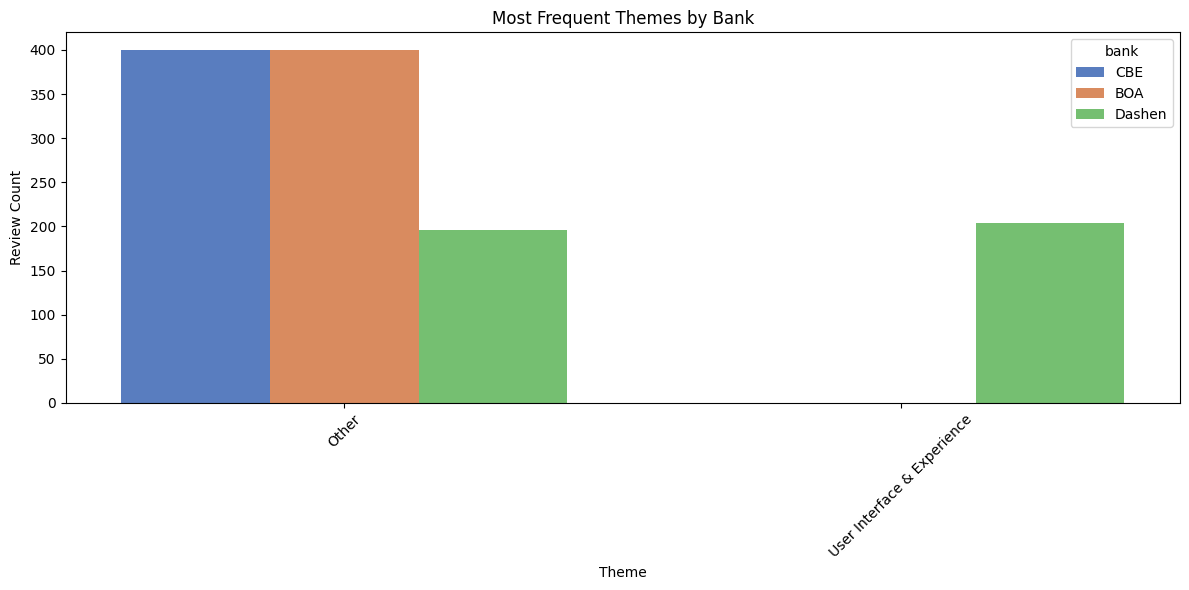

In [25]:
plt.figure(figsize=(12, 6))
sns.countplot(data=thematic_df, x='identified_theme', hue='bank', palette='muted',
              order=thematic_df['identified_theme'].value_counts().index)
plt.title('Most Frequent Themes by Bank')
plt.xlabel('Theme')
plt.ylabel('Review Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(
    output_dir, 'frequent_themes_by_bank.png'))
plt.show()

# Heatmap: Mean Sentiment per Theme and Bank

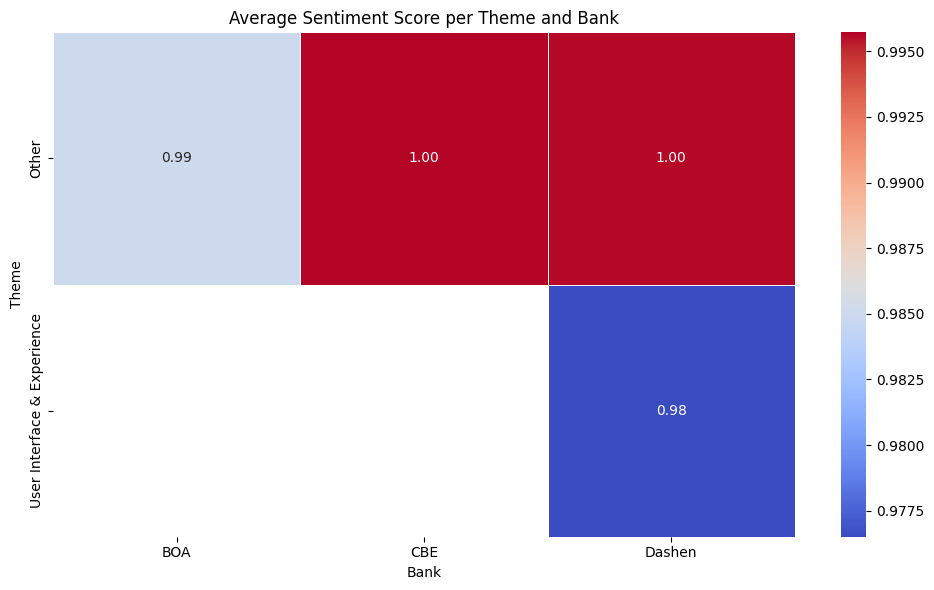

In [26]:
heatmap_data = merged_df.pivot_table(index='identified_theme', columns='bank',
                                     values='sentiment_score', aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f",
            cmap='coolwarm', linewidths=0.5)
plt.title('Average Sentiment Score per Theme and Bank')
plt.xlabel('Bank')
plt.ylabel('Theme')
plt.tight_layout()
plt.savefig(os.path.join(
    output_dir, 'average_sentiment_score.png'))
plt.show()

# WordCloud of Themes

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def generate_wordcloud(dataframe, bank, theme):
    """
    Generate and display a WordCloud for a specific bank and theme.
    """
    df = dataframe[
        (dataframe['bank'] == bank) &
        (dataframe['identified_theme'] == theme) &
        (dataframe['processed_text'].notna()) &
        (dataframe['processed_text'].str.strip() != '')
    ]

    if df.empty:
        print(f"⚠️ No data found for {bank} - {theme}")
        return

    theme_text = ' '.join(df['processed_text'])

    wordcloud = WordCloud(width=800, height=400,
                          background_color='white').generate(theme_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{bank} – Theme: {theme}', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(
        output_dir, f'{bank}_{theme}_wordcloud.png'))
    plt.show()

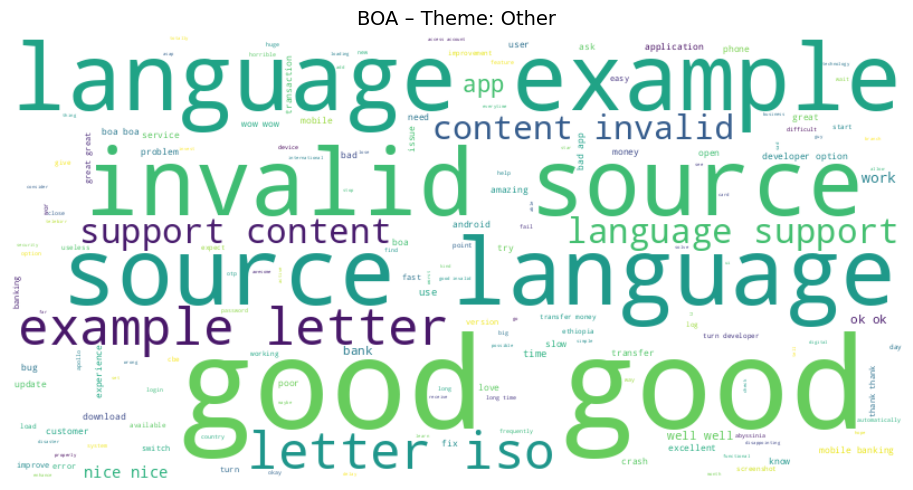

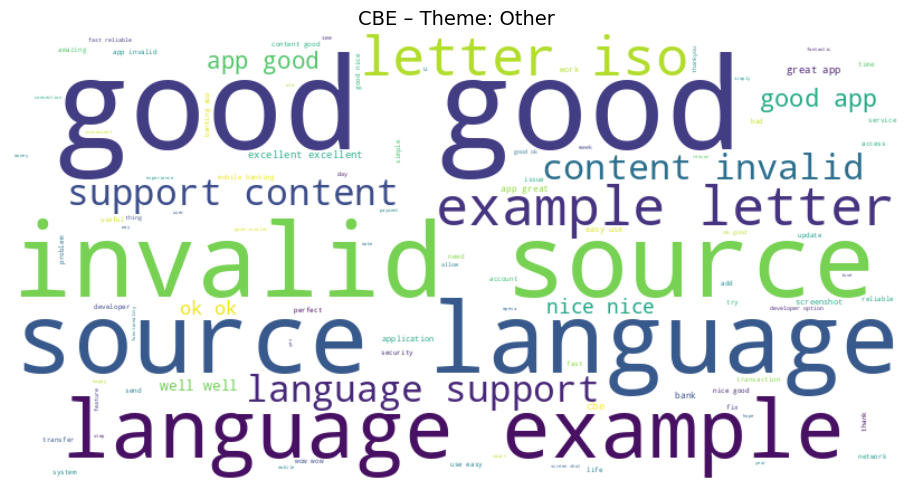

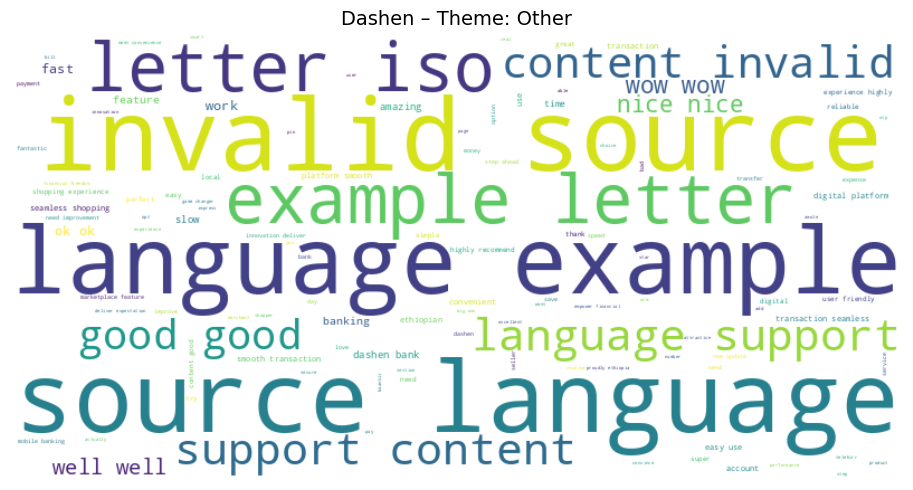

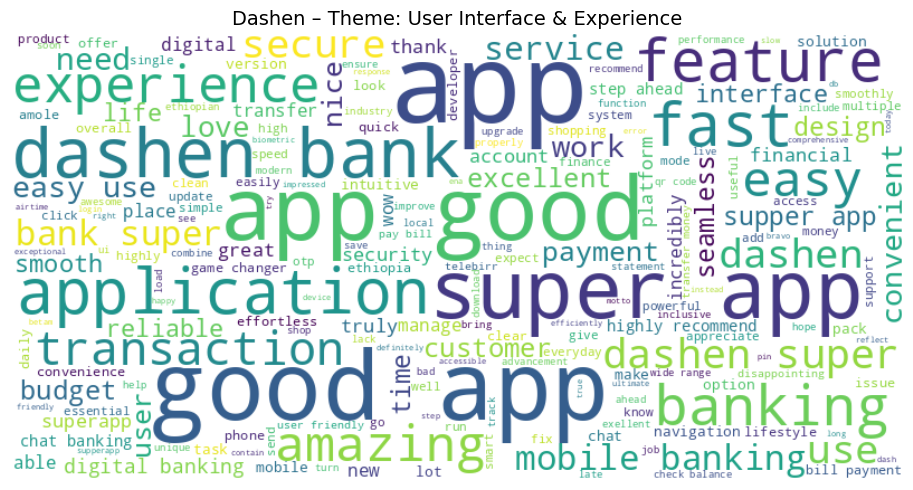

In [28]:
top_themes_per_bank = merged_df.groupby(
    ['bank', 'identified_theme']).size().reset_index(name='count')

top_themes = (
    top_themes_per_bank
    .sort_values(['bank', 'count'], ascending=[True, False])
    .groupby('bank')
    .head(3)
)


for _, row in top_themes.iterrows():
    bank = row['bank']
    theme = row['identified_theme']
    generate_wordcloud(merged_df, bank, theme)